# Ch 5. Análisis de datos interactivo

Este notebook introduce el análisis de datos interactivo de datos en BigQuery
utilizando un notebook de Jupyter gestionado por Vertex AI Workbench, el
cual es un entorno basado en notebooks de Jupyter que se proporciona a
través de instancias de máquina virtual (VM) con funciones que admiten
todo el flujo de trabajo de la ciencia de datos.

Puedes usar el entorno basado en notebooks de Vertex AI Workbench para
consultar y explorar datos, desarrollar y entrenar un modelo, y ejecutar
tu código como parte de un pipeline (canalización).

Esta celda, por ejemplo, es una celda de markdown. Es por eso que estás
viendo texto. La celda que sigue es una celda de código Python. La salida
de esa celda es lo que se imprime desde ella.

In [1]:
a = 3
b = a + 5
print(f"a={a} b={b}")

a=3 b=8


## Ruta relativa

Este notebook se creó en la carpeta 05_bqnotebook del repositorio de git.
Por lo tanto, es posible que veas una ruta que termine en eso. Pero la ruta
comenzará con /home/jupyter, que está mapeada a una carpeta local si se
ejecuta en un contenedor, de otro modo si estas en tu dispositivo local
veras la ruta local al archivo

In [2]:
!pwd

/home/inspired/data-science-on-gcp/05_bqnotebook


## ¿Qué está instalado?

¿Usamos !pip o %pip?

La primera opción ejecuta el comando en la shell y si no tenemos activado el ambiente ahi podría darnos resultados errados.

La segunda opción ejecuta pip por una función mágica, la cual ejecuta el
gestor de paquetes dentro del kernel(núcleo) actual 

In [ ]:
%pip freeze

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery

## Instalando dependencias

Las dependencias de Python regulares se pueden instalar utilizando pip

In [7]:
%pip install pytz

Note: you may need to restart the kernel to use updated packages.


## Juypter magic

In [9]:
%%html
Esta celda imprimirá un `string` de <b> HTML </b>.

El cell magic `%%bigquery` nos retorna los resultados de la consulta en
SQL en un DataFrame de pandas.


El sintaxis de la celda mágica es el siguiente:

```
%%bigquery [<destination_var>] [--project <project>] [--use_legacy_sql]
           [--verbose] [--params <params>] <query>
```

Obs. si nos encontramos en un ambiente local, antes de ejecutar la celda
debemos ejecutar la linea mágica load_ext la cual carga las funciones
mágicas por su nombre de módulo.

In [10]:
%load_ext google.cloud.bigquery

In [11]:
%%bigquery
SELECT
    COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM
    dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,frac_delayed
0,0.219494


## Acceso a llamadas a BigQuery

También podemos realizar llamadas a BigQuery directamente con la biblioteca
de Python:

In [6]:
bq = bigquery.Client()

In [7]:
sql = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""
bq.query(sql).to_dataframe()

,frac_delayed
0,0.219494


Grafiquemos una Función de Distribución de Probabilidad (PDF o Probability
Distribution Function) de diferentes retrasos de llegada. En un Notebook,
podemos asignar la salida de una consulta de la celda mágica a una variable,
en este caso df, como vimos en la sintáxis de la celda mágica %%biggquery:

In [12]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
type(df)

pandas.core.frame.DataFrame

In [14]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,1.734356e+06,1.743880e+06
mean,5.624196e+01,6.094439e+01
std,9.839818e+01,9.704787e+01
min,-8.100000e+01,1.000000e+01
25%,1.200000e+01,1.800000e+01
50%,3.000000e+01,3.300000e+01
75%,6.600000e+01,6.700000e+01
max,4.405000e+03,4.413000e+03


(-50.0, 300.0)

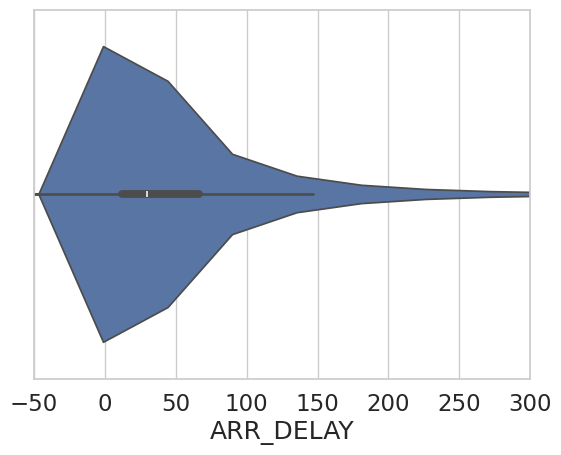

In [27]:
# predefined style {darkgrid=Default, whitegrid, dark, white, ticks}
sns.set_style(style="whitegrid")
# sns.set_theme(font_scale=1.5)  # Default font_scale=1
ax = sns.violinplot(data=df, x="ARR_DELAY", inner="box", orient="h")
ax.axes.set_xlim(-50, 300)

## Visualizando distribuciones

In [30]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,6.678463e+06,6.699431e+06
mean,8.216988e+00,1.346740e+01
std,5.887879e+01,5.711700e+01
min,-1.190000e+02,-7.200000e+01
25%,-1.400000e+01,-5.000000e+00
50%,-5.000000e+00,-2.000000e+00
75%,1.100000e+01,1.100000e+01
max,4.405000e+03,4.413000e+03


In [32]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
1,216.0,201.0,False
2,86.0,84.0,False
3,73.0,84.0,False
4,206.0,218.0,False
5,113.0,123.0,False


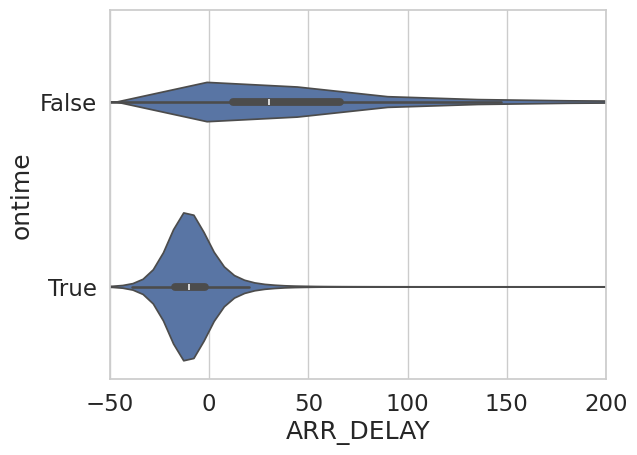

In [33]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

Podemos modificar el argumento gridsize, el cual es el número de puntos
en la malla discreta usada para evaluar la estimación de densidad del kernel
para obtener un gráfico mas "suave" a cambio de un mayor tiempo.

(-50.0, 200.0)

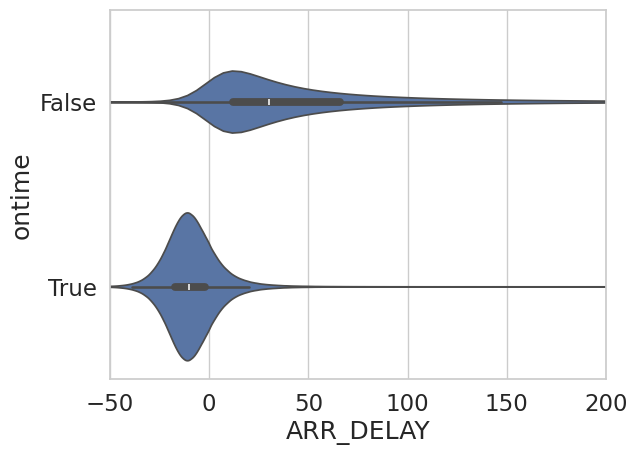

In [34]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

## Oddball values

La siguente consulta nos entrega el retraso de llegada promedio y el numero
de vuelos, asociados con cada valor de retraso de llegada

In [35]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
ORDER BY
    DEP_DELAY

Query is running:   0%|          |

Downloading:   0%|          |

El número de registros de cada grupo lo vemos a continuación

In [36]:
len(depdelay)

1865

Obtenemos mas de 1800 valores únicos, esto quiere decir que algo pasa con los
datos y tenemos valores fuera de lo común.

In [44]:
depdelay[:5]

,DEP_DELAY,arrival_delay,numflights
0,NaN,NaN,0
1,-72.0,-51.0,1
2,-68.0,-94.0,1
3,-59.0,-59.5,2
4,-55.0,-51.0,1


In [43]:
depdelay[55:60]

,DEP_DELAY,arrival_delay,numflights
55,-2.0,-7.583430,406258
56,-1.0,-6.353006,365784
57,0.0,-4.990917,313000
58,1.0,-4.024014,151784
59,2.0,-2.999148,126812


Las primeras filas tienen pocos vuelos, sin embargo los valores de retraso
pequeños tienen cantidades considerables, los valores poco comunes que
son una proporción pequeña con respecto al total de los datos pueden ser
probablemente ignorados sin afectar a nuestro modelo.

## Filtering Data on Occurence Frequency

In [45]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);

CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
))
;

SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

0    (1000, 234025, 0.4)
1    (500, 194535, 0.47)
2    (370, 185980, 0.49)
3     (300, 179887, 0.5)
4    (200, 169894, 0.52)
5    (100, 160616, 0.54)
6     (22, 148140, 0.57)
7      (10, 141085, 0.6)
8      (5, 140076, 0.61)
Name: stats, dtype: object

## Arrival delay conditioned on departure delay

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
depdelay[:5]

In [ ]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

In [ ]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']

ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 13
ax.plot(x, y, 'g.');

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

## Creating training/evaluation dataset

In [ ]:
%%bigquery
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE
LIMIT 5

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.trainday AS

SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
JOIN dsongcp.trainday USING(FL_DATE)
WHERE is_train_day = 'True'
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

In [ ]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

In [ ]:
print(df_eval['correct_nocancel'] /
      (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / 
      (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

In [ ]:
df_eval.head()

In [ ]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

In [ ]:
df_eval.head()

In [ ]:
print(df_eval['correct_nocancel'] / (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.